# Data Pre-Processing

In [1]:
import numpy as np
import os
# import tensorflow as tf
import keras

In [2]:
# initializing train and test lists

x_train, y_train, x_test, y_test= [], [], [], []

In [3]:
# loading data

faces_dir= 'att_faces/'

sub_f= sorted([f.path for f in os.scandir(faces_dir) if f.is_dir()])

In [4]:
from keras.preprocessing.image import  load_img, img_to_array
from keras.preprocessing import image

In [5]:
# loading data into list vars
from PIL import Image


for subject_id, folders in enumerate(sub_f):
    for file in sorted(os.listdir(folders)):
        img= load_img(folders+ '/' +file, color_mode= 'grayscale')
        img= img_to_array(img).astype('float32')/255
        if subject_id <35:
            x_train.append(img)
            y_train.append(subject_id)
        else:
            x_test.append(img)
            y_test.append(subject_id-35)

In [6]:
# images --> array
x_train= np.array(x_train)
y_train= np.array(y_train)

x_test= np.array(x_test)
y_test= np.array(y_test)

In [7]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, Input

## Designing the model

According to the SNN (Siamese Neural Net) architecture, only network is enough to create both the top and bottom instances. The reason being, that the single instance can be reused as the weights are to be shared.

In [8]:
def network(input_shape):
    model= Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu',
                     input_shape= input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation= 'sigmoid'))
    return model

In [9]:
# taking the input shape
input_shape= x_train.shape[1:]

# instantiating the shared network
shared_net= network(input_shape)

# defining the top and bottom inputs
top_input= Input(shape= input_shape)
bottom_input= Input(shape= input_shape)

# defining the top and bottom outputs
top_output= shared_net(top_input)
bottom_output= shared_net(bottom_input)


In [10]:
from keras import backend as k

# function to compute the euclidean distance
def euc_dist(vectors):
    vector1, vector2= vectors
    sum_of_squares= k.sum(k.square(vector1-vector2), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_of_squares, k.epsilon()))

### In the below code cell, we have used Lambda layer to define our own layer by wrapping an arbitary function as a Layer object.

In [11]:
from keras.layers import Lambda

# Euclidean function wrapped inside lambda layer
distance= Lambda(euc_dist, output_shape=(1,))([top_output, bottom_output])

In [12]:
# combining distance layer with the previously prepared top and bottom inputs

from keras.models import Model
model= Model( [top_input, bottom_input], outputs=distance)

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 112, 92, 1)] 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[0][0]      

# Training

In [14]:
import random

# creating pairs of araays of images with their labels

def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1
  
    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)
      
            # create negative pair
            # first, create list of classes that are different from the current class
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels)

        

In [15]:
num_classes= len(np.unique(y_train))
training_pairs, training_labels= create_pairs(x_train, y_train,
                                             num_classes)

test_pairs, test_labels= create_pairs(x_test, y_test, len(np.unique(y_test)))

# Defining the loss and accuracy

In [16]:
def contrastive_loss(y_true, D):
    margin = 1
    return k.mean(y_true * k.square(D) + (1 - y_true) * k.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return k.mean(k.equal(y_true, k.cast(y_pred < 0.5, y_true.dtype)))

In [17]:
# maintaining the same data type for bothe the input parameters
training_labels= k.cast(training_labels, training_pairs.dtype)

In [18]:
model.compile(loss= contrastive_loss, optimizer='adam', metrics= accuracy)

model.fit([training_pairs[:,0], training_pairs[:,1]], 
          training_labels, batch_size=128, epochs=10)

Epoch 1/10
5/5 [==============================] - 87s 17s/step - loss: 0.2576 - accuracy: 0.7658
Epoch 2/10
5/5 [==============================] - 28s 6s/step - loss: 0.1149 - accuracy: 0.9251
Epoch 3/10
5/5 [==============================] - 30s 6s/step - loss: 0.0829 - accuracy: 0.9453
Epoch 4/10
5/5 [==============================] - 36s 7s/step - loss: 0.0591 - accuracy: 0.9715
Epoch 5/10
5/5 [==============================] - 28s 6s/step - loss: 0.0403 - accuracy: 0.9953
Epoch 6/10
5/5 [==============================] - 60s 12s/step - loss: 0.0291 - accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 29s 6s/step - loss: 0.0202 - accuracy: 1.0000
Epoch 8/10
5/5 [==============================] - 28s 6s/step - loss: 0.0141 - accuracy: 1.0000
Epoch 9/10
5/5 [==============================] - 29s 6s/step - loss: 0.0103 - accuracy: 1.0000
Epoch 10/10
5/5 [==============================] - 47s 9s/step - loss: 0.0097 - accuracy: 1.0000


In [19]:
idx1, idx2= 1, 37
img1= np.expand_dims(x_test[idx1], axis=0)
img2= np.expand_dims(x_test[idx2], axis=0)

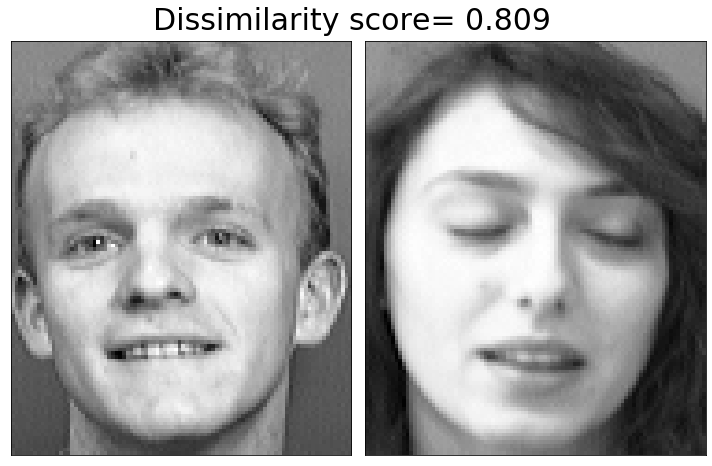

In [20]:
import matplotlib.pyplot as plt

fig, (ax1, ax2)= plt.subplots( 1, 2 , figsize=(10,7))
ax1.imshow(np.squeeze(img1), cmap='gray')
ax2.imshow(np.squeeze(img2), cmap='gray')
for ax in [ax1, ax2]:
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
dissimilarity= model.predict([img1, img2])[0][0]
fig.suptitle('Dissimilarity score={: .3f} '.format( dissimilarity), size=30)
plt.tight_layout()
plt.show()

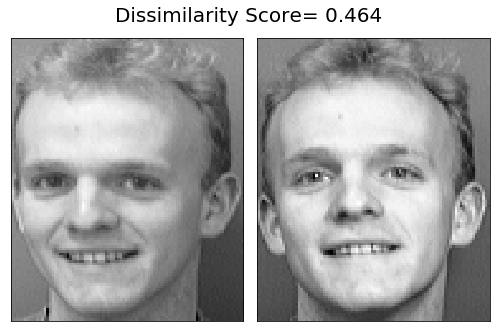

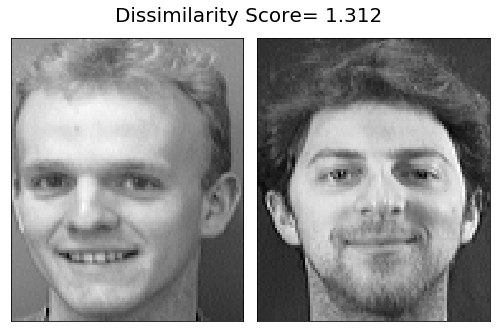

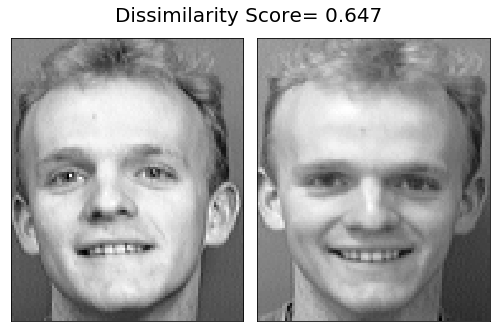

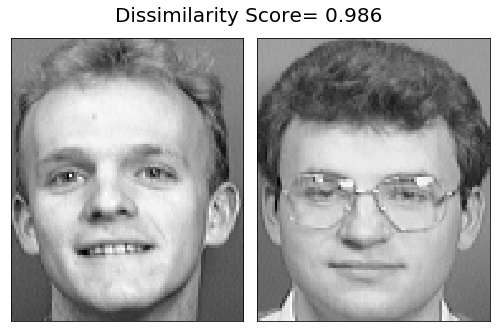

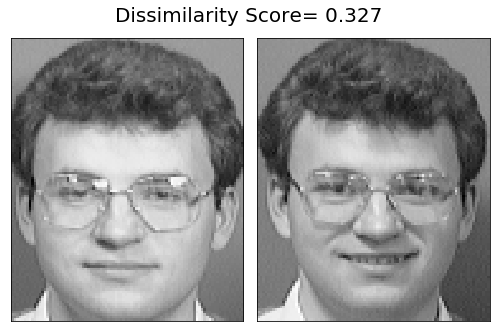

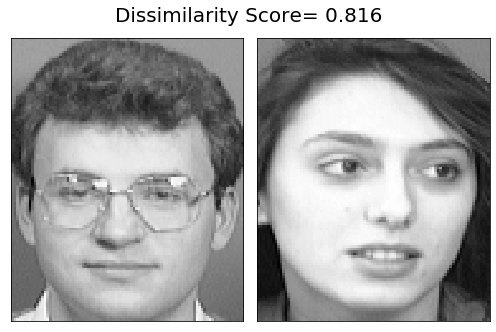

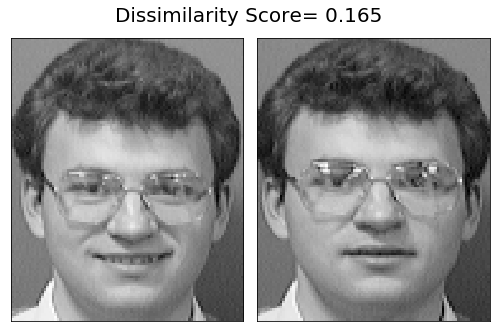

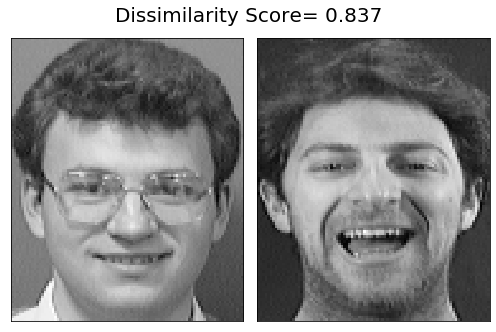

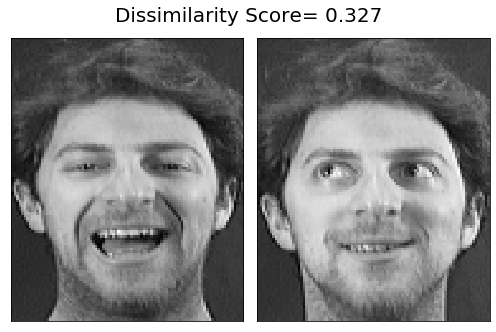

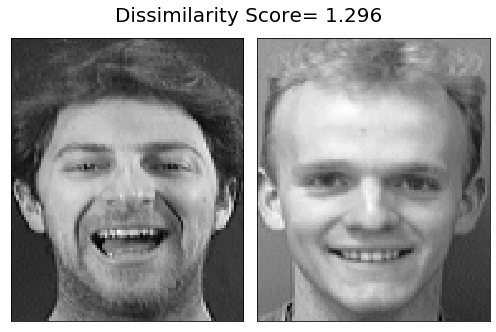

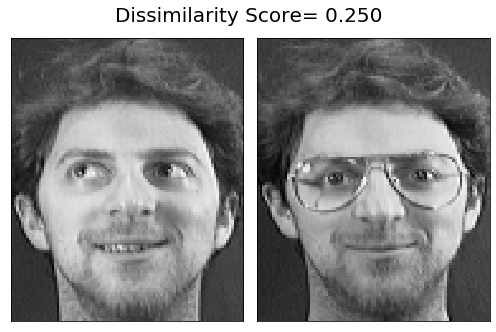

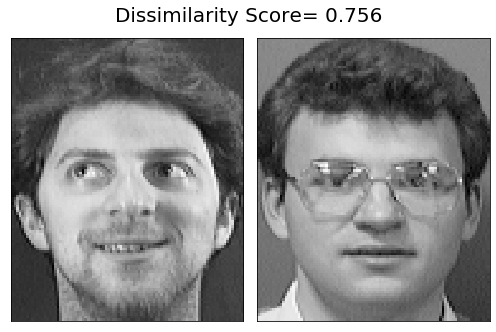

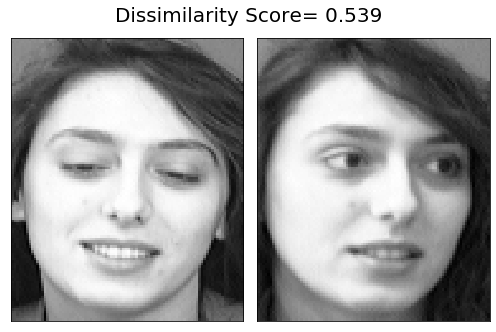

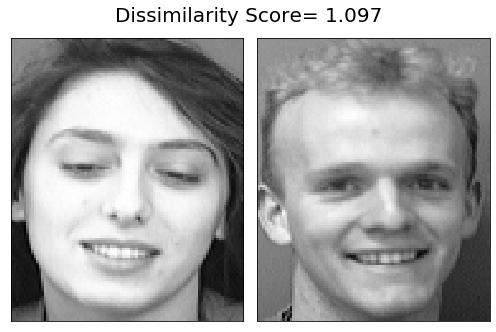

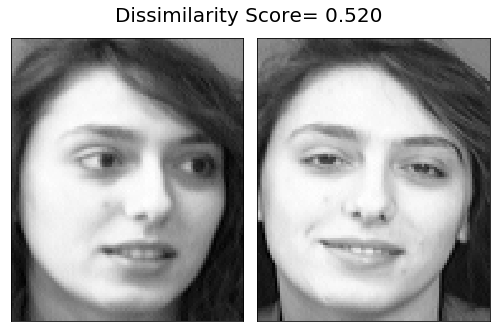

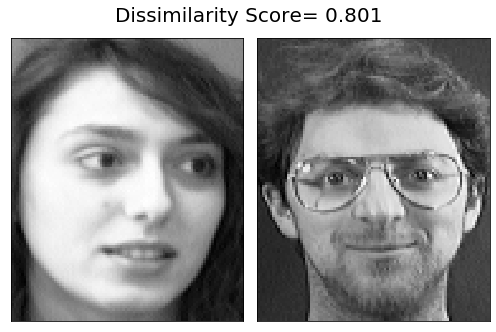

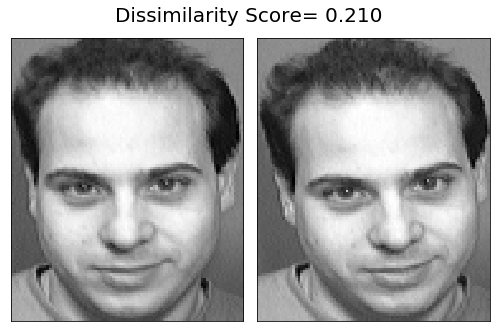

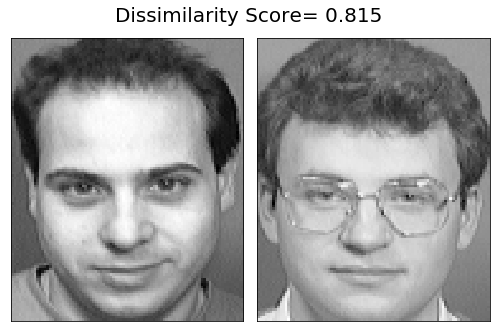

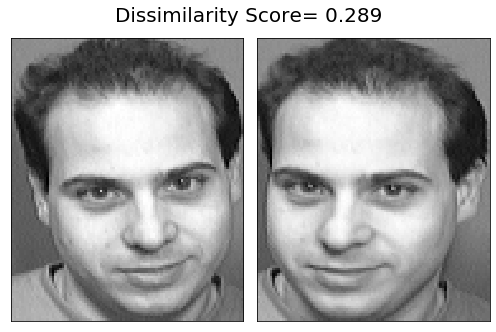

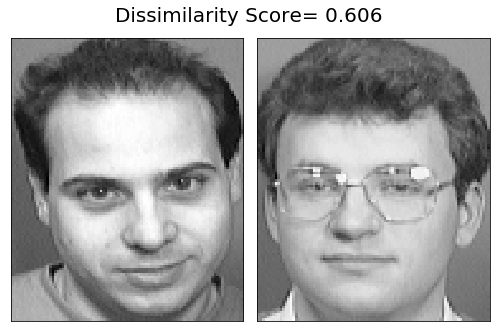

In [21]:
for i in range (5):
    for n in range (0,4):
        fig, (ax1, ax2)= plt.subplots(1,2, figsize=(7,5))
        img1= np.expand_dims(test_pairs[i*20 +n, 0], axis=0)
        img2= np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity= model.predict([img1, img2])[0][0]
        img1, img2= np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')
        
        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
        plt.tight_layout()
        fig.suptitle('Dissimilarity Score= {:.3f}'.format(dissimilarity), size=20)
plt.show()

In [22]:
model.save('siamese_nn.h5')

In [23]:
# serialize model to JSON
model_json = model.to_json()
model_yaml = model.to_yaml()

In [24]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
pred= model.predict([test_pairs[:, 0], test_pairs[:, 1]])

In [26]:
def get_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [27]:
get_accuracy(pred, test_labels)

1.0

# Face Detection and Onboarding Process

In [34]:
import cv2
import os

In [35]:
 cascade= cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [36]:
def face_detection(img, draw_box=True):
    global x,y, w, h
    gray_img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    face= cascade.detectMultiScale(gray_img, scaleFactor=1.6)
    
    for (x, y, w, h) in face:
        if draw_box:
            cv2.rectangle(img, (x,y), (x+w, y+h), (0,255,0), 5)
        
    face_box= img[y:y+h, x:x+w]
        
    face_coords= [x, y, w, h]
        
    return img, face_box, face_coords    

In [37]:
files= os.listdir('face_det_dataset')

images= [file for file in files if 'jpg' in file]

for image in images:
    img= cv2.imread('face_det_dataset/'+image)
    detected_faces, _, _ = face_detection(img)
    cv2.imwrite('face_det_dataset/detected_faces/'+ image, detected_faces)
    
    

## Image capture

In [38]:
video_capture= cv2.VideoCapture(0)

import math

In [39]:
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame

In [40]:
counter=10

while True:
    _, frame= video_capture.read()
    
    frame, face_box, face_coords= face_detection(frame)
    
    text= 'Image will be taken in{}...'. format(math.ceil(counter))
    
    if face_box is not None:
        frame= write_on_frame(frame, text, face_coords[0], face_coords[1]-10)
        
        cv2.imshow('Video', frame)
    
    cv2.waitKey(1)
    
    counter -= 0.1
    
    if counter <= 0:
        cv2.imwrite('true_img112.png', face_box)
        break

# Releasing the capture
video_capture.release()
cv2.destroyAllWindows()
print("Image Captured")

Image Captured


# Face Recognition

In [41]:
name= input("Enter your name")

Enter your name Anirudh


In [42]:
import cv2

In [43]:
true_img= cv2.imread('true_img12.png',0)
true_img= true_img.astype('float32')/255
true_img= cv2.resize(true_img, (93, 112))
true_img= true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)


In [44]:
import collections

In [46]:
video_capture = cv2.VideoCapture(0)
preds = collections.deque(maxlen=15)

while True:
    # Capture frame-by-frame
    _, frame = video_capture.read()

    # Detect Faces
    frame, face_img, face_coords = face_detection(frame, draw_box=False)
  
    if face_img is not None:
        face_img = cv2.cvtColor(face_img,  cv2.COLOR_BGR2GRAY)
        face_img = face_img.astype('float32')/255
        face_img = cv2.resize(face_img, (92, 112))
        face_img = face_img.reshape(1, face_img.shape[0], face_img.shape[1], 1)
        preds.append(1-model.predict([true_img, face_img])[0][0])
        x,y,w,h = face_coords
        if len(preds) == 15 and sum(preds)/15 >= 0.3:
            text = "Identity: {}".format(name)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)
        elif len(preds) < 15:
            text = "Identifying ..."
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 165, 255), 5)
        else:
            text = "Identity Unknown!"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 5)
        frame = write_on_frame(frame, text, face_coords[0], face_coords[1]-10)

    else:
        preds = collections.deque(maxlen=15) # clear existing predictions if no face detected 

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 